In [1]:
# Imports
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from pylightgbm.models import GBMRegressor
import operator
import matplotlib.pyplot as plt
import seaborn as sns
from bayes_opt import BayesianOptimization
import scipy.interpolate
from time import time
import os

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
FOLDS = 4
N_JOBS = 6
SEED = 2016
os.environ["LIGHTGBM_EXEC"] = "C:/Users/Julien/LightGBM/lightgbm.exe"

#DATA = "Base"
DATA = "Time"
#DATA = "Medians"
#DATA = "Lags"


In [2]:
# Get data
train = pd.read_csv("clean_data/train_" + DATA + ".csv")
y = pd.read_csv("clean_data/y.csv")

X_train = pd.read_csv("clean_data/X_train_" + DATA + ".csv")
y_train = pd.read_csv("clean_data/y_train.csv")

X_trainVal = pd.read_csv("clean_data/X_trainVal_" + DATA + ".csv")
y_trainVal = pd.read_csv("clean_data/y_trainVal.csv")

test = pd.read_csv("clean_data/test_" + DATA + ".csv")

X_test = pd.read_csv("clean_data/X_test_" + DATA + ".csv")
y_test = pd.read_csv("clean_data/y_test.csv")

X_testVal = pd.read_csv("clean_data/X_testVal_" + DATA + ".csv")
y_testVal = pd.read_csv("clean_data/y_testVal.csv")


In [3]:
def lgbm_mse(preds, dtrain) :
    labels = dtrain.get_label()
    return ("mse", mean_squared_error(preds, labels))

def run_lgbm(num_leaves, min_data_in_leaf, feature_fraction, bagging_fraction, bagging_freq, max_bin, max_depth, 
             X_trainVal, y_trainVal, X_testVal, y_testVal, X_train, y_train) :
    # Train model
    lg = GBMRegressor(
        config = "",
        tree_learner = "serial", 
        application = "regression", 
        num_threads = N_JOBS,
        metric = "l2",
        learning_rate = 0.1,
        num_iterations = 20000,
        early_stopping_round = 100, 
        num_leaves = int(num_leaves),
        min_data_in_leaf = int(min_data_in_leaf),
        feature_fraction = feature_fraction,
        feature_fraction_seed = SEED,
        bagging_fraction = bagging_fraction,
        bagging_freq = int(bagging_freq),
        bagging_seed = SEED,
        max_bin = int(max_bin),
        max_depth = int(max_depth),
        verbose = False
    )
    lg.fit(X_trainVal, y_trainVal, test_data = [(X_testVal, y_testVal)])
    
    lg = GBMRegressor(
        config = "",
        tree_learner = "serial", 
        application = "regression", 
        num_threads = N_JOBS,
        metric = "l2",
        learning_rate = 0.1,
        num_iterations = int(lg.best_round / 0.67),
        num_leaves = int(num_leaves),
        min_data_in_leaf = int(min_data_in_leaf),
        feature_fraction = feature_fraction,
        feature_fraction_seed = SEED,
        bagging_fraction = bagging_fraction,
        bagging_freq = int(bagging_freq),
        bagging_seed = SEED,
        max_bin = int(max_bin),
        max_depth = int(max_depth),
        verbose = False
    )
    lg.fit(X_train, y_train)

    return (lg)

In [4]:
def run_all(num_leaves, min_data_in_leaf, feature_fraction, bagging_fraction, bagging_freq, max_bin, max_depth) :
    # Generate y_test predictions to be able to optimize ensemble weights    
    lg = run_lgbm(num_leaves, min_data_in_leaf, feature_fraction, bagging_fraction, bagging_freq, max_bin, max_depth, 
                  X_trainVal, y_trainVal.TARGET, X_testVal, y_testVal.TARGET, X_train, y_train.TARGET)
    preds_y_test = lg.predict(X_test) 

    # Compute average error
    avgError = mean_squared_error(y_test.TARGET, preds_y_test)
    #print("avgError : " + str(avgError))    
    
    return((-1) * avgError)

In [5]:
num_leaves_min = 150
num_leaves_max = 500
min_data_in_leaf_min = 5
min_data_in_leaf_max = 30
feature_fraction_min = 0.2
feature_fraction_max = 1
bagging_fraction_min = 0.2
bagging_fraction_max = 1
bagging_freq_min = 0
bagging_freq_max = 100
max_bin_min = 150
max_bin_max = 500
max_depth_min = 7
max_depth_max = 30

start = time()
lgbmBO = BayesianOptimization(run_all, {
                                "num_leaves" : (num_leaves_min, num_leaves_max), 
                                "min_data_in_leaf" : (min_data_in_leaf_min, min_data_in_leaf_max),
                                "feature_fraction" : (feature_fraction_min, feature_fraction_max),
                                "bagging_fraction" : (bagging_fraction_min, bagging_fraction_max),
                                "bagging_freq" : (bagging_freq_min, bagging_freq_max),
                                "max_bin" : (max_bin_min, max_bin_max), 
                                "max_depth" : (max_depth_min, max_depth_max)      
    })

In [6]:
lgbmBO.explore({
              "num_leaves" : [500, 150, 400, 300, 400, 250, 350, 450, 350, 500],
              "min_data_in_leaf" : [5, 10, 8, 15, 4, 25, 7, 30, 6, 20], 
              "feature_fraction" : [0.5, 0.2, 0.3, 0.8, 0.9, 0.3, 0.7, 1, 0.7, 0.5],
              "bagging_fraction" : [0.2, 0.8, 0.4, 1, 0.5, 0.4, 0.3, 0.7, 0.8, 0.6],
              "bagging_freq" : [0, 50, 20, 70, 40, 10, 100, 90, 80, 60], 
              "max_bin" :  [200, 150, 250, 400, 350, 500, 300, 250, 450, 500],
              "max_depth" : [20, 8, 7, 12, 25, 14, 30, 10, 12, 15], 
              })

In [7]:
init_points = 10
num_iter = 130
lgbmBO.maximize(init_points = init_points, n_iter = num_iter)
print("BayesianOptimization took %.2f seconds" % ((time() - start)))

Initialization
------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   bagging_freq |   feature_fraction |   max_bin |   max_depth |   min_data_in_leaf |   num_leaves | 
    1 | 01m45s |  -98.89073 |             0.2000 |         0.0000 |             0.5000 |  200.0000 |     20.0000 |             5.0000 |     500.0000 | 
    2 | 01m05s | -118.36593 |             0.8000 |        50.0000 |             0.2000 |  150.0000 |      8.0000 |            10.0000 |     150.0000 | 
    3 | 00m51s | -114.09372 |             0.4000 |        20.0000 |             0.3000 |  250.0000 |      7.0000 |             8.0000 |     400.0000 | 
    4 | 01m32s |  -98.03919 |             1.0000 |        70.0000 |             0.8000 |  400.0000 |     12.0000 |            15.0000 |     300.0000 | 
    5 | 01m45s |  -97.64220 |             0.5000 |        40.0000 |       

C:\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00119598]), 'funcalls': 52, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)


   71 | 01m11s |  -96.27027 |             0.7500 |        89.4156 |             0.7220 |  464.6643 |     22.6367 |            28.8403 |     369.6819 | 
   72 | 01m39s |  -91.85908 |             0.9120 |        58.7047 |             0.8959 |  427.7523 |     28.9459 |            25.1643 |     226.7137 | 
   73 | 01m51s |  -99.49670 |             0.4849 |         0.4580 |             0.2444 |  497.8406 |     11.5014 |            29.3351 |     342.6685 | 
   74 | 01m00s | -105.12765 |             0.3441 |        16.3417 |             0.5135 |  283.8097 |     10.3592 |            28.9684 |     499.3406 | 
   75 | 00m42s | -127.92563 |             0.2882 |        68.7018 |             0.9574 |  447.9593 |     24.7544 |            14.4339 |     211.0214 | 
   76 | 01m07s | -107.99896 |             0.4433 |         4.4148 |             0.9713 |  181.6694 |     25.4059 |             9.0559 |     163.3008 | 
   77 | 01m30s |  -93.96841 |             0.9620 |        47.0153 |             0.7013 |

KeyboardInterrupt: 

In [8]:
history_df = pd.DataFrame(lgbmBO.res["all"]["params"])
history_df2 = pd.DataFrame(lgbmBO.res["all"]["values"])
history_df = pd.concat((history_df, history_df2), axis = 1)
history_df.rename(columns = { 0 : "RMSE"}, inplace = True)
history_df.index.names = ["Iteration"]
history_df.sort_values(["RMSE"], ascending = False, inplace = True)

#history_df = history_df[history_df.RMSE > -1]
display(history_df.head(10))

history_df.to_csv("./LGBM-BO.csv")

,bagging_fraction,bagging_freq,feature_fraction,max_bin,max_depth,min_data_in_leaf,num_leaves,RMSE
Iteration,,,,,,,,
51,0.912,58.705,0.896,427.752,28.946,25.164,226.714,-91.859
28,0.763,81.167,0.632,154.023,8.975,6.727,363.743,-92.754
78,0.685,58.365,0.847,481.811,24.527,29.203,376.018,-92.955
56,0.962,47.015,0.701,415.718,18.024,25.748,240.644,-93.968
38,1.000,100.000,1.000,150.000,30.000,30.000,227.588,-94.270
57,1.000,56.771,1.000,416.066,30.000,30.000,236.438,-94.438
15,1.000,100.000,1.000,449.927,30.000,5.000,317.797,-94.903
3,1.000,0.000,1.000,392.482,30.000,30.000,316.451,-95.097
69,1.000,0.000,1.000,426.050,30.000,30.000,237.036,-95.322


In [9]:
def graphBO(param1, param2, param1min, param1max, param2min, param2max, ratio) :
    x, y, z = history_df[param1].values, history_df[param2].values, history_df["RMSE"].values

    # Set up a regular grid of interpolation points
    xi, yi = np.linspace(param1min, param1max, 100), np.linspace(param2min, param2max, 100)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate
    rbf = scipy.interpolate.Rbf(x, y, z, function = "multiquadric", smooth = 0.5)
    zi = rbf(xi, yi)

    plt.figure()
    plt.imshow(zi, 
               cmap = "plasma", 
               aspect = ratio,
               vmin = z.min(), 
               vmax = z.max(), 
               origin = "lower",
               extent = [param1min, param1max, param2min, param2max])
    q = plt.scatter(x, y, c = z, cmap = "plasma")
    plt.colorbar(q)
    plt.xlabel(param1)
    plt.ylabel(param2)
    plt.savefig("figures/LGBM_" + param1 + "_" + param2 + ".png")
    plt.show(block = False)

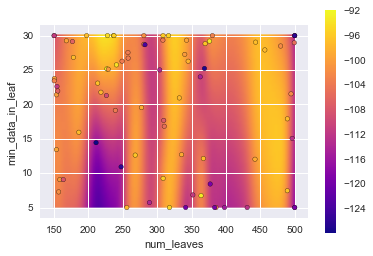

In [10]:
graphBO("num_leaves", "min_data_in_leaf", num_leaves_min, num_leaves_max, min_data_in_leaf_min, min_data_in_leaf_max, 10)

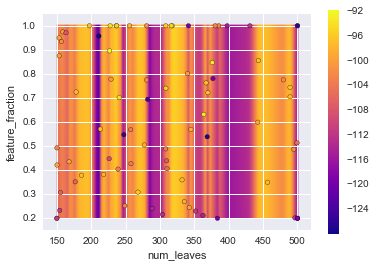

In [11]:
graphBO("num_leaves", "feature_fraction", num_leaves_min, num_leaves_max, feature_fraction_min, feature_fraction_max, 350)

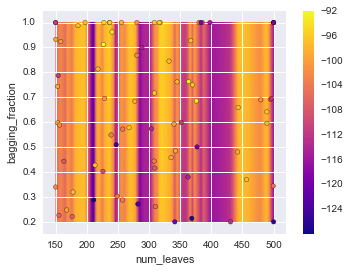

In [12]:
graphBO("num_leaves", "bagging_fraction", num_leaves_min, num_leaves_max, bagging_fraction_min, bagging_fraction_max, 400)

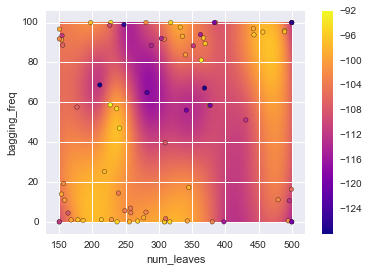

In [13]:
graphBO("num_leaves", "bagging_freq", num_leaves_min, num_leaves_max, bagging_freq_min, bagging_freq_max, 3)

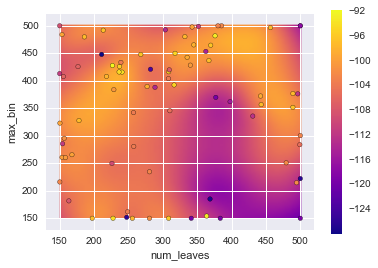

In [14]:
graphBO("num_leaves", "max_bin", num_leaves_min, num_leaves_max, max_bin_min, max_bin_max, 0.8)

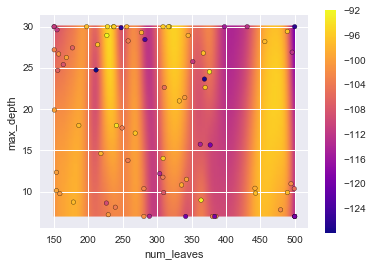

In [15]:
graphBO("num_leaves", "max_depth", num_leaves_min, num_leaves_max, max_depth_min, max_depth_max, 12)

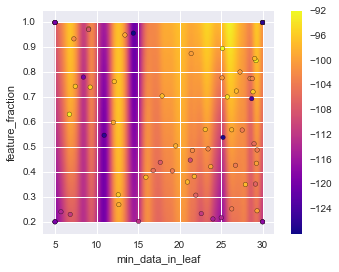

In [16]:
graphBO("min_data_in_leaf", "feature_fraction", min_data_in_leaf_min, min_data_in_leaf_max, feature_fraction_min, feature_fraction_max, 30)

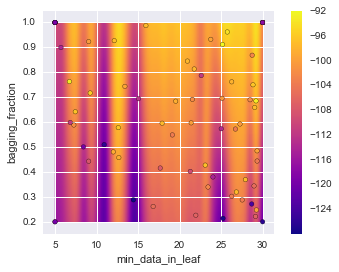

In [17]:
graphBO("min_data_in_leaf", "bagging_fraction", min_data_in_leaf_min, min_data_in_leaf_max, bagging_fraction_min, bagging_fraction_max, 30)

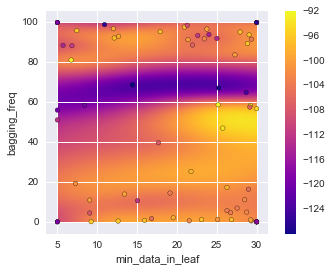

In [18]:
graphBO("min_data_in_leaf", "bagging_freq", min_data_in_leaf_min, min_data_in_leaf_max, bagging_freq_min, bagging_freq_max, 0.25)

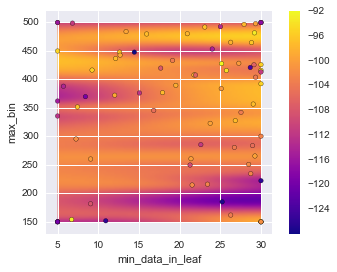

In [19]:
graphBO("min_data_in_leaf", "max_bin", min_data_in_leaf_min, min_data_in_leaf_max, max_bin_min, max_bin_max, 0.07)

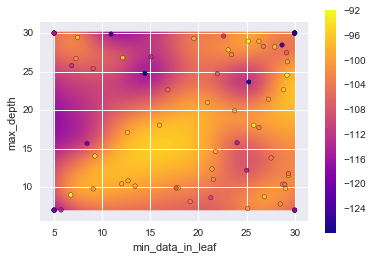

In [20]:
graphBO("min_data_in_leaf", "max_depth", min_data_in_leaf_min, min_data_in_leaf_max, max_depth_min, max_depth_max, 0.8)

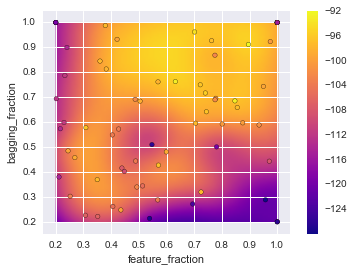

In [21]:
graphBO("feature_fraction", "bagging_fraction", feature_fraction_min, feature_fraction_max, bagging_fraction_min, bagging_fraction_max, 0.9)

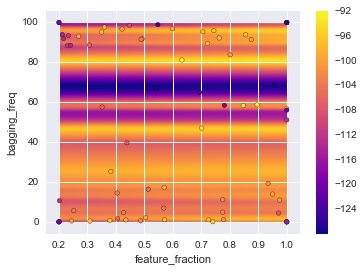

In [22]:
graphBO("feature_fraction", "bagging_freq", feature_fraction_min, feature_fraction_max, bagging_freq_min, bagging_freq_max, 0.007)

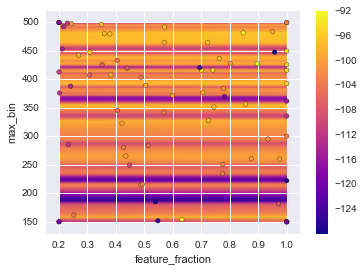

In [23]:
graphBO("feature_fraction", "max_bin", feature_fraction_min, feature_fraction_max, max_bin_min, max_bin_max, 0.002)

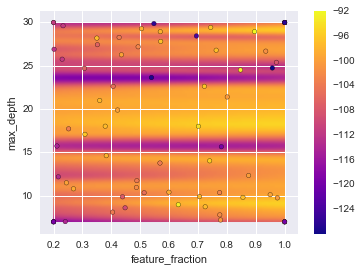

In [24]:
graphBO("feature_fraction", "max_depth", feature_fraction_min, feature_fraction_max, max_depth_min, max_depth_max, 0.03)

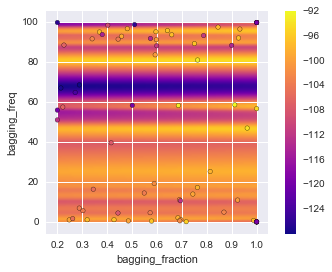

In [25]:
graphBO("bagging_fraction", "bagging_freq", bagging_fraction_min, bagging_fraction_max, bagging_freq_min, bagging_freq_max, 0.008)

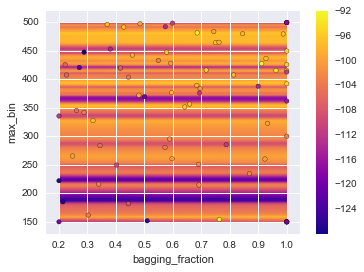

In [26]:
graphBO("bagging_fraction", "max_bin", bagging_fraction_min, bagging_fraction_max, max_bin_min, max_bin_max, 0.002)

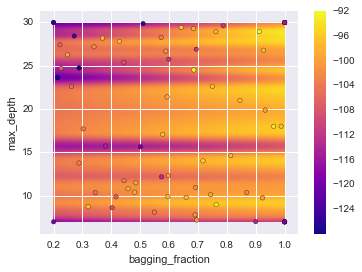

In [27]:
graphBO("bagging_fraction", "max_depth", bagging_fraction_min, bagging_fraction_max, max_depth_min, max_depth_max, 0.03)

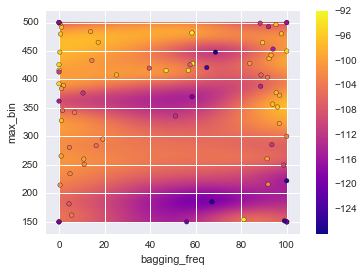

In [28]:
graphBO("bagging_freq", "max_bin", bagging_freq_min, bagging_freq_max, max_bin_min, max_bin_max, 0.25)

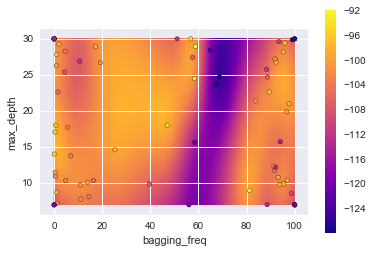

In [29]:
graphBO("bagging_freq", "max_depth", bagging_freq_min, bagging_freq_max, max_depth_min, max_depth_max, 3)

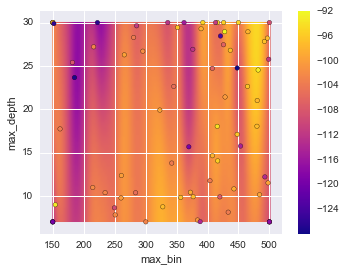

In [30]:
graphBO("max_bin", "max_depth", max_bin_min, max_bin_max, max_depth_min, max_depth_max, 14)